<a href="https://colab.research.google.com/github/nwferreri/predictive-analytics-prophet/blob/main/predictive_analytics_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Analytics - Prophet

Predict the demand for shelter in NYC.  How many people need shelter in a given week?

1. Prepare dataframe
2. Train and test set
3. Create model and assess accuracy
4. Visualize the output
5. Permorm parameter tuning, including cross-validation

## 0. Directory, Libraries, Data

In [ ]:
# Directory
%cd /content/drive/MyDrive/ZTM/Python for Business/Predictive Analytics/Prophet

/content/drive/MyDrive/ZTM/Python for Business/Predictive Analytics/Prophet


In [ ]:
# Libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

In [ ]:
# Data
df = pd.read_csv('DHS_weekly.csv')
df

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143
...,...,...,...,...,...,...
361,12/6/2020,375444,0,0,0,10.072857
362,12/13/2020,375820,0,0,0,8.208571
363,12/20/2020,375615,0,0,0,3.535714
364,12/27/2020,374203,0,0,1,7.510000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          366 non-null    object 
 1   Total Individuals in Shelter  366 non-null    int64  
 2   Easter                        366 non-null    int64  
 3   Thanksgiving                  366 non-null    int64  
 4   Christmas                     366 non-null    int64  
 5   Temperature                   366 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 17.3+ KB


In [ ]:
df.describe()

,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
count,366.000000,366.000000,366.000000,366.000000,366.000000
mean,405042.808743,0.019126,0.019126,0.019126,14.842424
std,19375.509125,0.137154,0.137154,0.137154,8.511113
min,212514.000000,0.000000,0.000000,0.000000,-4.318571
25%,397040.250000,0.000000,0.000000,0.000000,7.503571
50%,408495.000000,0.000000,0.000000,0.000000,14.918571
75%,418908.750000,0.000000,0.000000,0.000000,22.792143
max,428607.000000,1.000000,1.000000,1.000000,28.535714


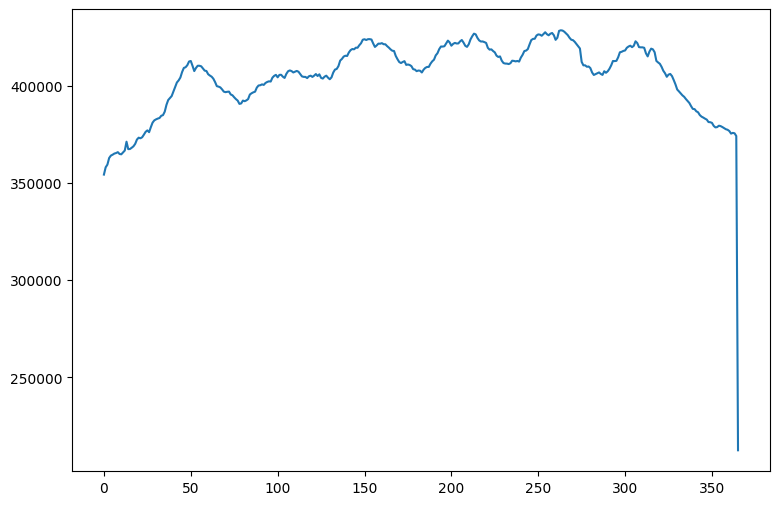

In [ ]:
# Plotting
df['Total Individuals in Shelter'].plot(figsize=(9, 6));

## 1. Prepare dataframe

In [ ]:
# Transform date variable
df.Date = pd.to_datetime(df.Date,
                         format='%m/%d/%Y')
df.Date

0     2014-01-05
1     2014-01-12
2     2014-01-19
3     2014-01-26
4     2014-02-02
         ...    
361   2020-12-06
362   2020-12-13
363   2020-12-20
364   2020-12-27
365   2021-01-03
Name: Date, Length: 366, dtype: datetime64[ns]

In [ ]:
# Change variable names
df = df.rename(columns={'Date': 'ds',
                        'Total Individuals in Shelter': 'y'})
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848000
1,2014-01-12,358103,0,0,0,3.257143
2,2014-01-19,359491,0,0,0,5.632857
3,2014-01-26,362880,0,0,0,-1.850000
4,2014-02-02,364125,0,0,0,1.177143


In [ ]:
# Create holidays dataframe
def make_holidays_df(df, holiday_dict):
  '''
  Makes the holidays dataframe used with Prophet.

  Parameters
  df: The DataFrame of time-series data.

  holiday_dict: A 3D dictionary for each holiday with the 'name',
  'lower_window', and 'upper_window' to be used in the returned DataFrame.
  '''
  holidays = pd.DataFrame()

  for holiday, dictionary in holiday_dict.items():
    # Get dates
    dates = pd.to_datetime(df[df[holiday] == 1].ds)

    # Create holiday df
    holiday_df = pd.DataFrame({'holiday': dictionary['name'],
                               'ds': dates,
                               'lower_window': dictionary['lower_window'],
                               'upper_window': dictionary['upper_window']})

    # Combine holidays df
    holidays = pd.concat([holidays, holiday_df])

  return holidays

In [ ]:
holiday_dict = {'Easter': {'name': 'easter',
                           'lower_window': -7,
                           'upper_window': 7},
                'Thanksgiving': {'name': 'thanksgiving',
                                 'lower_window': -7,
                                 'upper_window': 7}}

In [ ]:
holidays = make_holidays_df(df, holiday_dict)
holidays

,holiday,ds,lower_window,upper_window
15,easter,2014-04-20,-7,7
65,easter,2015-04-05,-7,7
116,easter,2016-03-27,-7,7
171,easter,2017-04-16,-7,7
221,easter,2018-04-01,-7,7
276,easter,2019-04-21,-7,7
327,easter,2020-04-12,-7,7
47,thanksgiving,2014-11-30,-7,7
99,thanksgiving,2015-11-29,-7,7
151,thanksgiving,2016-11-27,-7,7


In [ ]:
# Drop holiday columns from df
df = df.drop(columns=['Easter', 'Thanksgiving'])
df.head()

,ds,y,Christmas,Temperature
0,2014-01-05,354354,0,0.848000
1,2014-01-12,358103,0,3.257143
2,2014-01-19,359491,0,5.632857
3,2014-01-26,362880,0,-1.850000
4,2014-02-02,364125,0,1.177143


## 2. Training and test set

In [ ]:
# Training and test split
test_weeks = 4
training = df.iloc[:-test_weeks, :]
test = df.iloc[-test_weeks:, :]
training.tail(1), test.head(1)

(            ds       y  Christmas  Temperature
 361 2020-12-06  375444          0    10.072857,
             ds       y  Christmas  Temperature
 362 2020-12-13  375820          0     8.208571)

## 3. Create model and assess accuracy

In [ ]:
# Prophet model
m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=False,
            holidays=holidays,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcbedl1k4/g0vvehls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcbedl1k4/76q2_wr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53933', 'data', 'file=/tmp/tmpcbedl1k4/g0vvehls.json', 'init=/tmp/tmpcbedl1k4/76q2_wr1.json', 'output', 'file=/tmp/tmpcbedl1k4/prophet_modelgb4pdqtk/prophet_model-20230803211036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Regressor coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.000000,-0.000185,-0.000185,-0.000185
1,Temperature,multiplicative,14.934939,-0.000224,-0.000224,-0.000224


In [ ]:
# Create future dataframe
future = m.make_future_dataframe(periods=test_weeks,
                                 freq='W')
future = pd.concat([future, df.iloc[:, 2:]],
                   axis=1)
future

,ds,Christmas,Temperature
0,2014-01-05,0,0.848000
1,2014-01-12,0,3.257143
2,2014-01-19,0,5.632857
3,2014-01-26,0,-1.850000
4,2014-02-02,0,1.177143
...,...,...,...
361,2020-12-06,0,10.072857
362,2020-12-13,0,8.208571
363,2020-12-20,0,3.535714
364,2020-12-27,1,7.510000


In [ ]:
# Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Temperature,...,thanksgiving,thanksgiving_lower,thanksgiving_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-05,349705.165977,351940.011714,357772.051878,349705.165977,349705.165977,0.0,0.0,0.0,0.003004,...,0.0,0.0,0.0,0.011913,0.011913,0.011913,0.0,0.0,0.0,354921.963349
1,2014-01-12,351105.820409,354141.295072,360181.860154,351105.820409,351105.820409,0.0,0.0,0.0,0.002491,...,0.0,0.0,0.0,0.014341,0.014341,0.014341,0.0,0.0,0.0,357015.452662
2,2014-01-19,352506.474841,356213.714393,362467.939012,352506.474841,352506.474841,0.0,0.0,0.0,0.001984,...,0.0,0.0,0.0,0.017814,0.017814,0.017814,0.0,0.0,0.0,359485.328271
3,2014-01-26,353907.129274,359183.342769,365061.170428,353907.129274,353907.129274,0.0,0.0,0.0,0.003580,...,0.0,0.0,0.0,0.019743,0.019743,0.019743,0.0,0.0,0.0,362161.062381
4,2014-02-02,355307.783706,360143.582797,366000.762835,355307.783706,355307.783706,0.0,0.0,0.0,0.002934,...,0.0,0.0,0.0,0.019095,0.019095,0.019095,0.0,0.0,0.0,363134.893394


In [ ]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'Temperature',
       'Temperature_lower', 'Temperature_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'thanksgiving', 'thanksgiving_lower',
       'thanksgiving_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

In [ ]:
# Easter assessment
holiday = 'easter'
forecast[(forecast[holiday].abs() > 0) &
         (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,easter
326,2020-04-05,-0.003293
327,2020-04-12,-0.003981
328,2020-04-19,-0.003020


In [ ]:
# Thanksgiving assessment
holiday = 'thanksgiving'
forecast[(forecast[holiday].abs() > 0) &
         (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,thanksgiving
359,2020-11-22,0.002184
360,2020-11-29,-0.000964
361,2020-12-06,-0.003939


In [ ]:
# Retrieve predictions
y_preds = forecast.yhat[-test_weeks:]
y_preds

362    385746.627112
363    384845.636217
364    382634.863871
365    381561.069159
Name: yhat, dtype: float64

In [ ]:
# Accuracy assessment
print(mean_absolute_error(test.y, y_preds))
print(np.sqrt(mean_squared_error(test.y, y_preds)))

49159.04908959706
84899.57374804457


## 4. Visualize the output

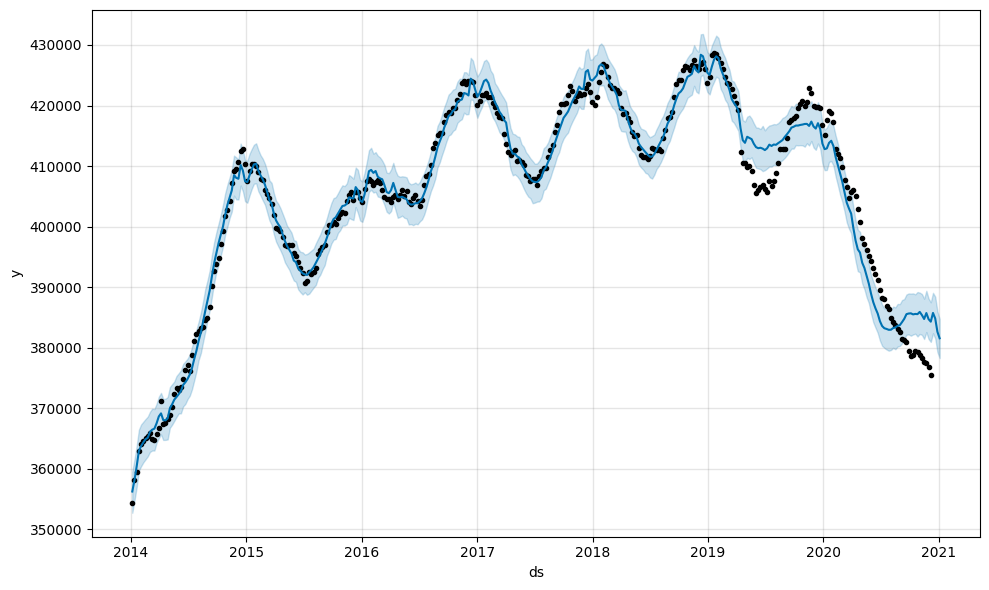

In [ ]:
# Visualize the forecast
m.plot(forecast);

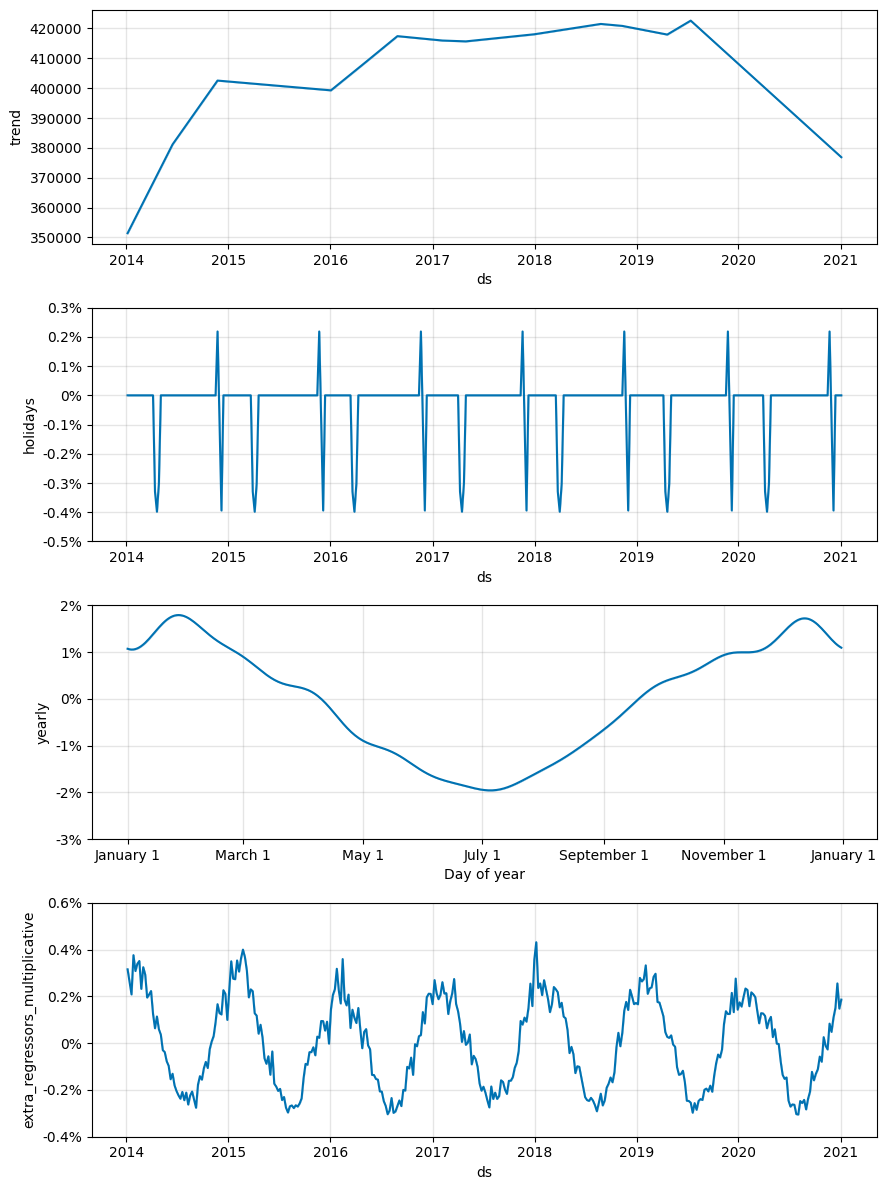

In [ ]:
# Plot components
m.plot_components(forecast);

## 5. Perform parameter tuning

Including cross-validation

In [ ]:
# Parameter Grid
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(grid)

54

In [ ]:
# Tuning

# Storing variable
rmse = []

# Loop
for params in grid:
  # Build model
  m = Prophet(growth='linear',
              yearly_seasonality=True,
              weekly_seasonality=False,
              holidays=holidays,
              seasonality_mode=params['seasonality_mode'],
              seasonality_prior_scale=params['seasonality_prior_scale'],
              holidays_prior_scale=params['holidays_prior_scale'],
              changepoint_prior_scale=params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.add_regressor('Temperature')
  m.fit(training)

  # Cross-validation
  df_cv = cross_validation(model=m,
                           horizon='4 W',
                           initial='300 W',
                           parallel='processes')

  # Measure and store results
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)

In [ ]:
# Get best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,9059.021025
1,0.01,5,additive,10,9076.092696
2,0.01,5,additive,20,9106.839260
3,0.01,5,multiplicative,5,8948.491857
4,0.01,5,multiplicative,10,9012.177870
5,0.01,5,multiplicative,20,8962.158162
6,0.01,10,additive,5,9088.853855
7,0.01,10,additive,10,9126.490148
8,0.01,10,additive,20,9085.282223
9,0.01,10,multiplicative,5,8929.634015


## Model with Best Parameters

In [ ]:
# Prophet model
m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=False,
            holidays=holidays,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=5,
            holidays_prior_scale=20,
            changepoint_prior_scale=0.1)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.fit(training)

In [ ]:
# Create future dataframe
future = m.make_future_dataframe(periods=test_weeks,
                                 freq='W')
future = pd.concat([future, df.iloc[:, 2:]],
                   axis=1)

# Forecasting
forecast = m.predict(future)

# Retrieve predictions
y_preds = forecast.yhat[-test_weeks:]

# Accuracy assessment
print(mean_absolute_error(test.y, y_preds))
print(np.sqrt(mean_squared_error(test.y, y_preds)))

49004.05852088555
84901.05524567212


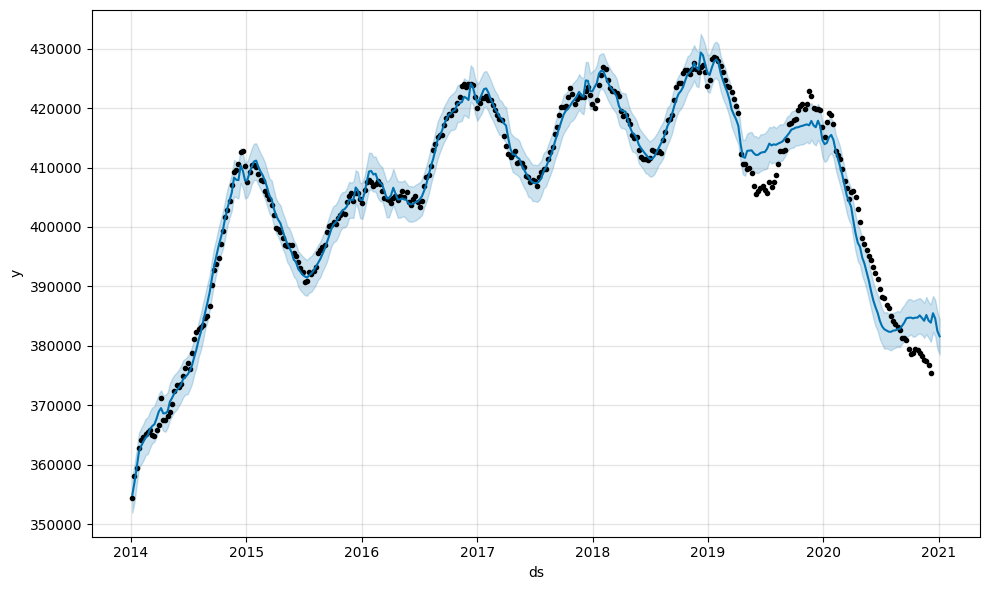

In [ ]:
# Visualize the forecast
m.plot(forecast);

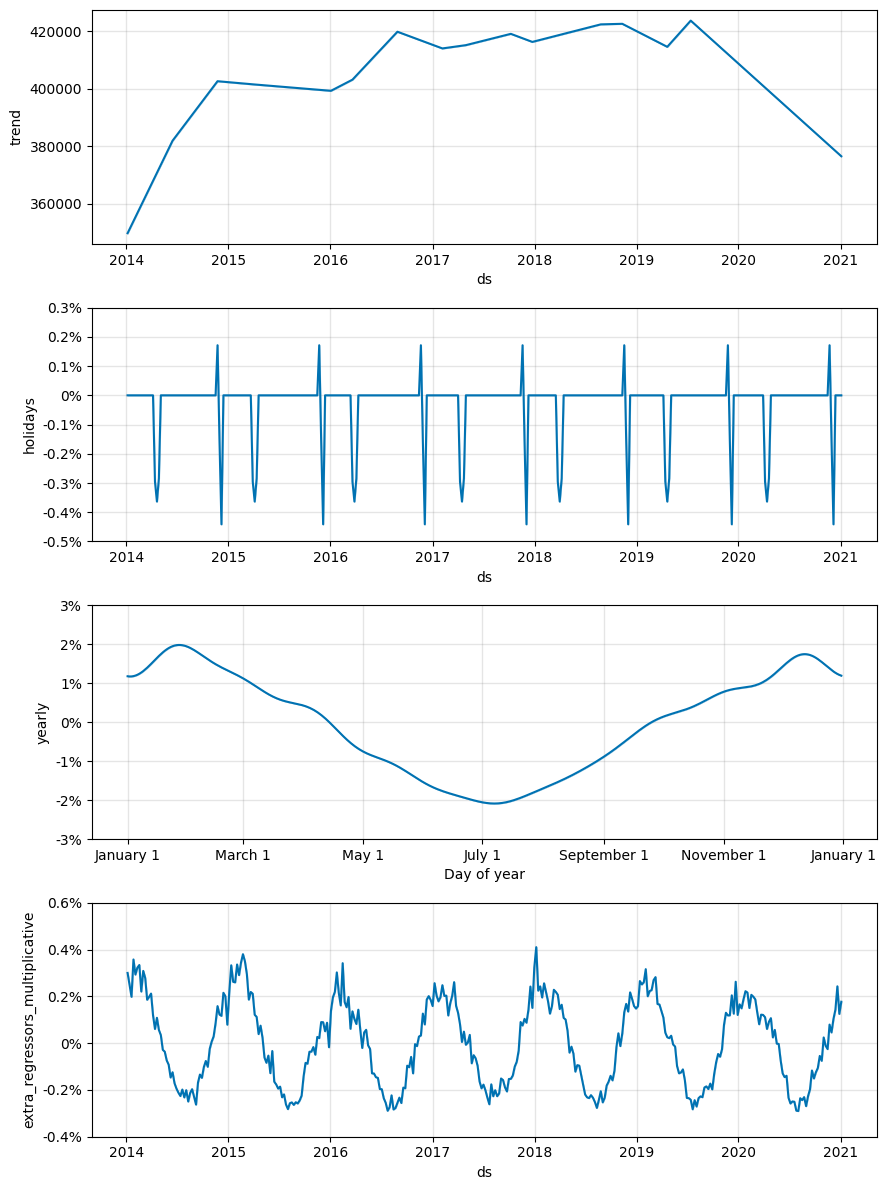

In [ ]:
# Plot components
m.plot_components(forecast);